In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import pickle

In [0]:
data_path = '/content/drive/My Drive/Mineria de datos/datasets/ready/'

training_sets_paths = sorted(glob.glob(data_path + "training*.pkl"))
test_sets_paths = sorted(glob.glob(data_path + 'test*.pkl'))

In [0]:
dataset_index = 0

In [0]:
training = pd.read_pickle(training_sets_paths[dataset_index])
test = pd.read_pickle(test_sets_paths[dataset_index])

In [0]:
TRAINING = training.iloc[256000:512000,:]
TEST= test.iloc[256000:512000,:]

In [0]:
TRAINING.info(verbose=True)

**One Hot Encoding**

In [0]:
columns_fe = []

for i in range(1, 3):
    columns_fe.append('hist_user_behavior_reason_start'+str(i))
    columns_fe.append('hist_user_behavior_reason_end'+str(i))
    columns_fe.append('mode'+str(i))
    columns_fe.append('context_type'+str(i))

In [0]:
from sklearn.preprocessing import OneHotEncoder, LabelEncoder

ENCODED_training = []
ENCODED_test = []
for column in columns_fe:
    le = LabelEncoder()
    ohe = OneHotEncoder()

    le.fit(pd.concat([TRAINING[column], TEST[column]], ignore_index=True))

    TEMP_train = le.transform(TRAINING[column])
    TEMP_test  = le.transform(TEST[column])

    ohe.fit(np.append(TEMP_train, TEMP_test).reshape(-1,1))

    X_train = ohe.transform(TEMP_train.reshape(-1,1)).toarray()
    X_test  = ohe.transform(TEMP_test.reshape(-1,1)).toarray()


    ENCODED_training.append(
        pd.DataFrame(X_train, columns=[column+str(i) for i in range(X_train.shape[1])])
    )

    ENCODED_test.append(
        pd.DataFrame(X_test, columns=[column+str(i) for i in range(X_test.shape[1])])
    )

In [0]:
TRAINING = pd.concat([TRAINING] + ENCODED_training, axis=1)
TEST = pd.concat([TEST] + ENCODED_test, axis=1)

In [0]:
TRAINING.drop(columns_fe, axis=1, inplace=True)
TEST.drop(columns_fe, axis=1, inplace=True)

In [0]:
TRAINING

,session_id,context_switch1,no_pause_before_play1,short_pause_before_play1,long_pause_before_play1,hist_user_behavior_n_seekfwd1,hist_user_behavior_n_seekback1,hist_user_behavior_is_shuffle1,hour_of_day1,premium1,duration1,us_popularity_estimate1,pca11,pca21,pca31,pca41,pca51,pca61,pca71,pca81,pca91,pca101,pca111,pca121,pca131,pca141,pca151,context_switch2,no_pause_before_play2,short_pause_before_play2,long_pause_before_play2,hist_user_behavior_n_seekfwd2,hist_user_behavior_n_seekback2,hist_user_behavior_is_shuffle2,hour_of_day2,premium2,duration2,us_popularity_estimate2,pca12,pca22,...,hist_user_behavior_reason_end11,hist_user_behavior_reason_end12,hist_user_behavior_reason_end13,hist_user_behavior_reason_end14,hist_user_behavior_reason_end15,hist_user_behavior_reason_end16,hist_user_behavior_reason_end17,mode10,mode11,context_type10,context_type11,context_type12,context_type13,context_type14,context_type15,hist_user_behavior_reason_start20,hist_user_behavior_reason_start21,hist_user_behavior_reason_start22,hist_user_behavior_reason_start23,hist_user_behavior_reason_start24,hist_user_behavior_reason_start25,hist_user_behavior_reason_start26,hist_user_behavior_reason_start27,hist_user_behavior_reason_start28,hist_user_behavior_reason_end20,hist_user_behavior_reason_end21,hist_user_behavior_reason_end22,hist_user_behavior_reason_end23,hist_user_behavior_reason_end24,hist_user_behavior_reason_end25,hist_user_behavior_reason_end26,hist_user_behavior_reason_end27,mode20,mode21,context_type20,context_type21,context_type22,context_type23,context_type24,context_type25
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
511995,1_97baad57-9421-49c9-bc9b-eb81508a7964,False,True,False,False,0.0,0.000000,False,0.347826,True,0.043314,0.936476,4.423125,0.184979,1.485630,-0.473747,-1.427446,-0.444837,0.502490,-0.819458,-0.026688,0.578879,1.237720,-0.723472,0.608108,-0.031862,-1.254779,False,True,False,False,0.0,0.000000,False,0.347826,True,0.164838,0.984221,-3.270647,1.315903,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Na

**Getting ready**

In [0]:
features_column = list(TRAINING.columns)
features_column.remove('skip')
features_column.remove('session_length')
features_column.remove('session_position')
features_column.remove('session_id')
target = ["skip"]

In [0]:
split_cant_start = 1000
train_indexes = list(TRAINING.index.values)

train_splits = []
split_size = split_cant_start
while split_size < len(train_indexes):
    train_splits.append(train_indexes[:split_size])
    del train_indexes[:split_size]
    split_size = split_size*2

train_splits.append(train_indexes)

for s in train_splits:
    print(len(s))

1000
2000
4000
8000
16000
32000
64000
128000
256000
1000


In [0]:
split_cant_start = 1000
test_indexes = list(TEST.index.values)

tests_splits = []
split_size = split_cant_start
while split_size < len(test_indexes):
    tests_splits.append(test_indexes[:split_size])
    del test_indexes[:split_size]
    split_size = split_size*2

tests_splits.append(test_indexes)

for s in tests_splits:
    print(len(s))

1000
2000
4000
8000
16000
32000
64000
128000
256000
1000


In [0]:
lista_train_splits = []
for s in train_splits:
  valor = len(s)
  lista_train_splits.append(valor)

In [0]:
X_train = TRAINING.loc[:,features_column] #X
y_train = TRAINING.loc[:,'skip']
X_test = TEST.loc[:,features_column]
y_test = TEST.loc[:,'skip'] #y

In [0]:
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import learning_curve
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score

***DECISION TREE***

*Decision Tree Default*

In [0]:
from sklearn import metrics

In [0]:
listaScores = []
for i in range(11):
  X_train = TRAINING.loc[train_splits[i],features_column]
  y_train = TRAINING.loc[train_splits[i],'skip']
  X_test = TEST.loc[tests_splits[i],features_column]
  y_test = TEST.loc[tests_splits[i],'skip']
  clf = DecisionTreeClassifier()
  clf.fit(X_train, y_train)
  y_pred = clf.predict(X_test)
  listaScores.append(metrics.accuracy_score(y_test, y_pred))
  metrics.accuracy_score(y_test, y_pred)

In [0]:
listaScores

[0.857,
 0.824,
 0.82675,
 0.8295,
 0.8244375,
 0.82696875,
 0.825546875,
 0.8283125,
 0.83089453125,
 0.830712890625,
 0.8295297454005419]

*Decision Tree Default - cross validation_ stratified kfold 10*

In [0]:
listaScores = []
for i in range(10):
  X = TRAINING.loc[train_splits[i],features_column]
  y = TEST.loc[tests_splits[i],'skip']
  clf = DecisionTreeClassifier()
  skf = StratifiedKFold(n_splits=10, random_state=None, shuffle=False)
  scores = cross_val_score(clf, X, y, cv=skf)
  listaScores.append(list(scores))

In [0]:
listaScores

[[0.34, 0.31, 0.3, 0.37, 0.43, 0.41, 0.38, 0.44, 0.54, 0.53],
 [0.52, 0.475, 0.6, 0.47, 0.46, 0.46, 0.455, 0.535, 0.505, 0.575],
 [0.445, 0.5, 0.51, 0.4975, 0.48, 0.4925, 0.485, 0.49, 0.4725, 0.49],
 [0.49375, 0.53, 0.48875, 0.48625, 0.4725, 0.465, 0.5, 0.45625, 0.4975, 0.495],
 [0.501875,
  0.480625,
  0.505,
  0.483125,
  0.503125,
  0.476875,
  0.47875,
  0.4925,
  0.464375,
  0.476875],
 [0.505,
  0.498125,
  0.4996875,
  0.498125,
  0.5134375,
  0.51,
  0.505625,
  0.49125,
  0.4884375,
  0.4875],
 [0.50109375,
  0.5028125,
  0.50453125,
  0.50265625,
  0.500625,
  0.50109375,
  0.496875,
  0.495625,
  0.498125,
  0.4946875],
 [0.50515625,
  0.50921875,
  0.509921875,
  0.49875,
  0.49484375,
  0.494296875,
  0.495703125,
  0.504609375,
  0.50609375,
  0.497578125],
 [0.4987890625,
  0.49703125,
  0.4961328125,
  0.5015234375,
  0.5057421875,
  0.502734375,
  0.4988671875,
  0.4980859375,
  0.502578125,
  0.500390625],
 [0.49974609375,
  0.498125,
  0.502265625,
  0.5002734375,
  

**EVALUACION DE PARAMETROS**

*Evaluación de Decision Tree por Default*

In [0]:
from sklearn.metrics import roc_curve, auc

In [0]:
X_train = TRAINING.loc[train_splits[9],features_column]
y_train = TRAINING.loc[train_splits[9],'skip']
X_test = TEST.loc[tests_splits[9],features_column]
y_test = TEST.loc[tests_splits[9],'skip']

In [0]:
dt = DecisionTreeClassifier()
dt.fit(X_train, y_train)
y_pred = dt.predict(X_test)

In [0]:
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(false_positive_rate, true_positive_rate)
roc_auc

0.8306440407946077

*Cambiar parametros de la profundidad del arbol desde el 1 al 32*

Parametros:

In [0]:
max_depths = np.linspace(1, 32, 32, endpoint=True)
min_samples_splits = np.linspace(0.1, 1.0, 10, endpoint=True)
min_samples_leafs = np.linspace(0.1, 0.5, 5, endpoint=True)
max_features = [10,20,30,40,50]

max_depths

In [0]:
train_results = []
test_results = []
for max_depth in max_depths:
   dt = DecisionTreeClassifier(max_depth=max_depth)
   dt.fit(X_train, y_train)
   train_pred = dt.predict(X_train)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   # Add auc score to previous train results
   train_results.append(roc_auc)
   y_pred = dt.predict(X_test)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   # Add auc score to previous test results
   test_results.append(roc_auc)

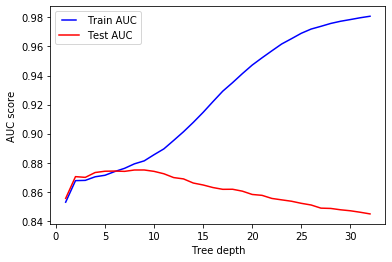

In [0]:
from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(max_depths, train_results, 'b', label='Train AUC')
line2, = plt.plot(max_depths, test_results, 'r', label='Test AUC')
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('AUC score')
plt.xlabel('Tree depth')
plt.show()

min_samples_splits

In [0]:
train_results = []
test_results = []
for min_samples_split in min_samples_splits:
   dt = DecisionTreeClassifier(min_samples_split=min_samples_split)
   dt.fit(X_train, y_train)
   train_pred = dt.predict(X_train)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   train_results.append(roc_auc)
   y_pred = dt.predict(X_test)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   test_results.append(roc_auc)

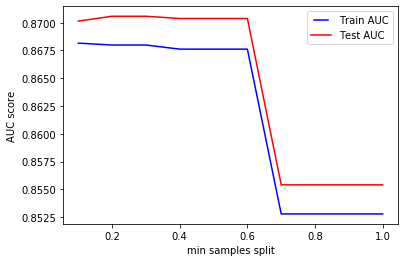

In [0]:
from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(min_samples_splits, train_results, 'b', label='Train AUC')
line2, = plt.plot(min_samples_splits, test_results, 'r', label='Test AUC')
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('AUC score')
plt.xlabel('min samples split')
plt.show()

min_samples_leaf

In [0]:
train_results = []
test_results = []
for min_samples_leaf in min_samples_leafs:
   dt = DecisionTreeClassifier(min_samples_leaf=min_samples_leaf)
   dt.fit(X_train, y_train)
   train_pred = dt.predict(X_train)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   train_results.append(roc_auc)
   y_pred = dt.predict(X_test)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   test_results.append(roc_auc)

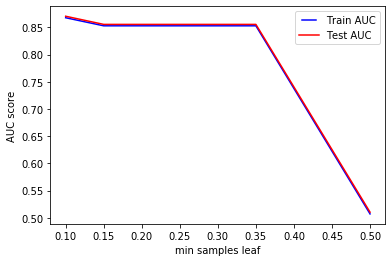

In [0]:
from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(min_samples_leafs, train_results, 'b', label='Train AUC')
line2, = plt.plot(min_samples_leafs, test_results, 'r', label='Test AUC')
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('AUC score')
plt.xlabel('min samples leaf')
plt.show()

max_features

In [0]:
train_results = []
test_results = []
for max_feature in max_features:
   dt = DecisionTreeClassifier(max_features=max_feature)
   dt.fit(X_train, y_train)
   train_pred = dt.predict(X_train)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   train_results.append(roc_auc)
   y_pred = dt.predict(X_test)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   test_results.append(roc_auc)

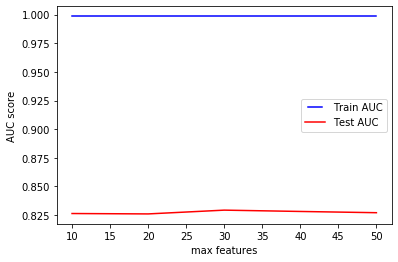

In [0]:
from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(max_features, train_results, 'b', label='Train AUC')
line2, = plt.plot(max_features, test_results, 'r', label='Test AUC')
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('AUC score')
plt.xlabel('max features')
plt.show()

*Construccion del modelo con los mejores parametros*


In [0]:
X_train = TRAINING.loc[:,features_column]
y_train = TRAINING.loc[:,'skip']
X_test = TEST.loc[:,features_column]
y_test = TEST.loc[:,'skip']

In [0]:
max_depths = 6
min_samples_splits = 0.15 #20
min_samples_leafs = 0.15
max_features = 30

In [0]:
clf = DecisionTreeClassifier(max_depth = max_depths, min_samples_split = min_samples_splits, min_samples_leaf=min_samples_leafs, max_features= max_features)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

ValueError: ignored

In [0]:
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(false_positive_rate, true_positive_rate)
roc_auc

0.8541317552130803

*Curva de aprendizaje del datasetSin pruning*

In [0]:
from sklearn.model_selection import learning_curve

In [0]:
clf = DecisionTreeClassifier(max_depth = max_depths, min_samples_split = min_samples_splits, min_samples_leaf=min_samples_leafs, max_features= max_features)
train_sizes, train_scores, test_scores = learning_curve(
estimator = clf,
X = X_train,
y = y_train, train_sizes = lista_train_splits[0:9], cv = 10,scoring='accuracy')

In [0]:
print('Training scores:\n\n', train_scores)
print('\n', '-' * 70) # separator to make the output easy to read
print('\nValidation scores:\n\n', test_scores)

Training scores:

 [[0.8        0.745      0.852      0.852      0.809      0.73
  0.776      0.852      0.852      0.734     ]
 [0.8315     0.763      0.7475     0.7225     0.8525     0.8525
  0.7485     0.8525     0.761      0.755     ]
 [0.845      0.778      0.8535     0.74175    0.74775    0.8535
  0.74325    0.8535     0.768      0.768     ]
 [0.80025    0.740625   0.856125   0.774125   0.755125   0.78225
  0.739875   0.817875   0.725875   0.774125  ]
 [0.743      0.7831875  0.7831875  0.7831875  0.658      0.7425625
  0.7860625  0.7895     0.86125    0.7189375 ]
 [0.7466875  0.79096875 0.859625   0.7353125  0.79096875 0.7373125
  0.77615625 0.78503125 0.79096875 0.7520625 ]
 [0.78025    0.76496875 0.75053125 0.70251562 0.76979688 0.6944375
  0.79157813 0.78579687 0.7378125  0.744     ]
 [0.81870312 0.81953906 0.85751563 0.74992187 0.73776562 0.74992187
  0.74992187 0.73409375 0.85594531 0.71316406]
 [0.85526172 0.74468359 0.6608125  0.78391406 0.78320312 0.78635937
  0.74427734 

In [0]:
train_scores_mean = train_scores.mean(axis = 1)
validation_scores_mean = test_scores.mean(axis = 1)
print('Mean training scores\n\n', pd.Series(train_scores_mean, index = lista_train_splits[0:9]))
print('\n', '-' * 20) # separator
print('\nMean validation scores\n\n',pd.Series(validation_scores_mean, index = lista_train_splits[0:9]))

Mean training scores

 1000      0.800200
2000      0.788650
4000      0.795225
8000      0.776625
16000     0.764888
32000     0.776509
64000     0.752169
128000    0.778649
256000    0.781453
dtype: float64

 --------------------

Mean validation scores

 1000      0.801348
2000      0.784979
4000      0.801381
8000      0.776289
16000     0.762473
32000     0.775418
64000     0.751043
128000    0.776299
256000    0.782328
dtype: float64


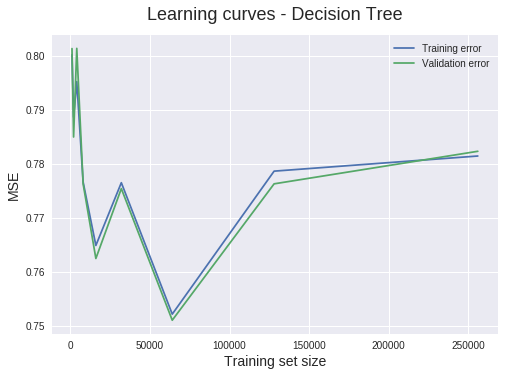

In [0]:
plt.style.use('seaborn')
plt.plot(train_sizes, train_scores_mean, label = 'Training error')
plt.plot(train_sizes, validation_scores_mean, label = 'Validation error')
plt.ylabel('MSE', fontsize = 14)
plt.xlabel('Training set size', fontsize = 14)
plt.title('Learning curves - Decision Tree', fontsize = 18, y = 1.03)
plt.legend()

**Confusion Matrix**

In [0]:
from sklearn.metrics import confusion_matrix, classification_report


In [0]:
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

**Recall - Precision**

In [0]:
precision = tp / (tp + fp)
precision

0.8383621554387514

In [0]:
recall = tp / (tp + fn)
recall

0.8258532440070354

In [0]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       False       0.82      0.84      0.83    246996
        True       0.84      0.83      0.83    253005

    accuracy                           0.83    500001
   macro avg       0.83      0.83      0.83    500001
weighted avg       0.83      0.83      0.83    500001



In [0]:
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.8314163371673257
